# 比赛介绍

In [1]:
root = "I:/data/dogcat/train/train/"

In [2]:
##数据可视化
import os
from PIL import Image
cat1 = Image.open(os.path.join(root,'cat.200.jpg'))
dog1 = Image.open(os.path.join(root,'dog.200.jpg'))

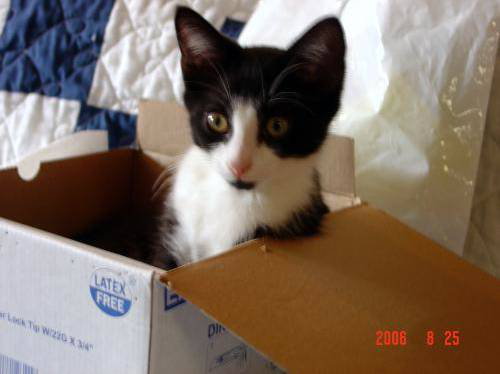

In [3]:
cat1

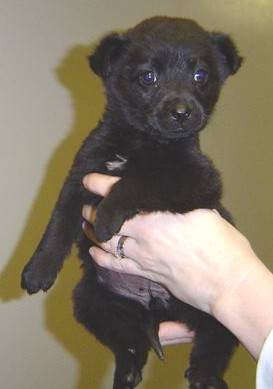

In [7]:
dog1

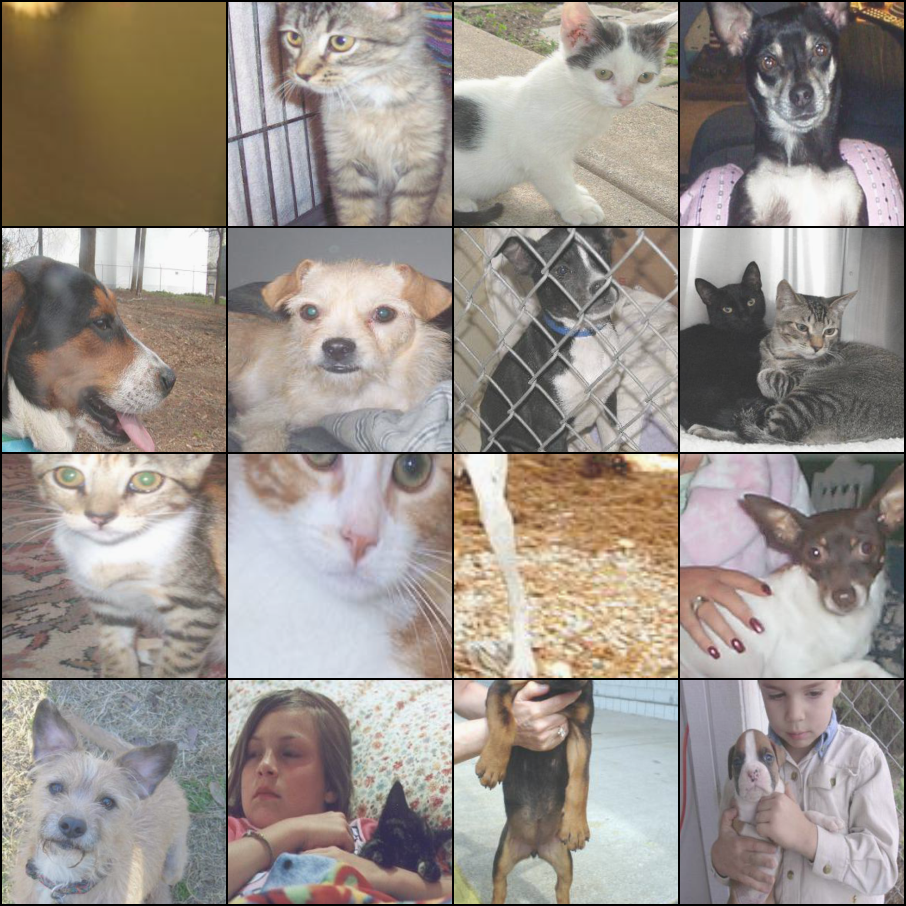

In [26]:
###拼接图片
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.transforms import ToPILImage
from torchvision import transforms
#在这样Normalize之后，神经网络在训练的过程中，梯度对每一张图片的作用都是平均的，也就是不存在比例不匹配的情况。
normalize = transforms.Normalize(mean=[0.4,0.4,0.4,],std=[0.5,0.5,0.5])
trans = transforms.Compose([
    transforms.RandomResizedCrop(224),##随机裁剪
    transforms.RandomHorizontalFlip(),##水平翻折
    transforms.ToTensor(),
    normalize #归一化
])
to_imgs = ToPILImage()
datasets = ImageFolder("I:/data/dogcat/dogcat_2/",transform=trans)
dataloader = DataLoader(datasets,shuffle=True,batch_size=16)
dataiter = iter(dataloader)
img = make_grid(next(dataiter)[0]*0.4+0.5,4)###拼接网格
to_imgs(img)

# 数据加载

In [3]:
import os
from PIL import Image
from torch.utils import data
import numpy as np
from torchvision import transforms as T

In [4]:
class DogCat(data.Dataset):
    '''
    Dataset，加载猫狗数据集
    '''
    def __init__(self,root,transforms=None,train=True,test=False):
        """
        目标：获取所有图片地址，并根据地址训练、验证、测试划分数据
        """
        self.test = test
        imgs = [os.path.join(root,img) for img in os.listdir(root)]
        
        ##test1: I:/data/dogcat/test/test/1.jpg
        ##train: I:/data/dogcat/train/train/cat.0.jpg
        if self.test:
            imgs = sorted(imgs, key=lambda x: int(x.split('.')[-2].split('/')[-1]))###按照id排序
            print("测试集的数目为：",len(imgs))
        else:
            imgs = sorted(imgs, key= lambda x:int(x.split('.')[-2]))
            print("训练集的数目为：",len(imgs))
        
        imgs_num = len(imgs)
        
        #划分训练集、验证集，训练验证7：3
        if self.test:
            self.imgs = imgs
        elif train:
            self.imgs = imgs[:int(0.7*imgs_num)]
        else:
            self.imgs = imgs[int(0.7*imgs_num):]
        
        if transforms is None:
            
            ##对数据进行转换，如果没有指定transform，这里设置一个默认的转换,对训练测试验证处理有所区别
            """normalize = T.Normalize(mean=[0.485,0.456,0.406],
                                   std = [0.229,0.224,0.225])###测试集验证集和训练集有所区别的原因是数据数目不同"""
            normalize = T.Normalize(mean=[0.48,0.48,0.48],
                                   std = [0.229,0.229,0.229])##先设置为一致的
            
            ##测试集和验证集
            if self.test or not train:
                self.transforms = T.Compose([
                    T.Resize(224),
                    T.CenterCrop(224),#图片不是统一大小，所以从中间裁剪出224的，这里会对分类效果有影响
                    T.ToTensor(),
                    normalize
                ])
            ##训练集
            else:
                self.transforms = T.Compose([
                    T.Resize(256),
                    T.RandomResizedCrop(224),###因为训练集要训练多个epoch  所以随机选取  不能直接裁成224，不然选的都一样了
                    T.RandomHorizontalFlip(),#数据增强
                    T.ToTensor(),
                    normalize
                ])
            
            
    def __getitem__(self,index):
        """
        返回一张图片的数据
        如果是测试集，没有图片id，如1000.jpg返回1000
        """
        img_pth = self.imgs[index]
        if self.test:
            label = int(self.imgs[index].split('.')[-2].split('/')[-1])
        else:
            label = 1 if 'dog' in img_pth.split('/')[-1] else 0 ###狗是1 猫是0
        data = Image.open(img_pth)
        data = self.transforms(data)
        return data,label

    def __len__(self):
        '''
        返回数据集中所有图片的个数
        '''
        return len(self.imgs)

训练集的数目为： 20


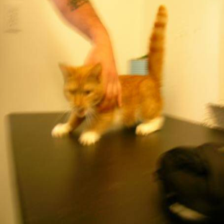

In [6]:
###加载数据测试
train_dataset = DogCat("I:/data/dogcat/dogcat_1/",train=True)
train_loader = DataLoader(train_dataset,batch_size=4,shuffle=True)
train_iter = iter(train_dataset)
to_imgs(next(train_iter)[0]*0.229+0.48)

In [25]:
###正式加载数据  #所有的参数从配置文件 opt中获取
train_dataset = DogCat(root,train=True)#opt.train_data_root
trainloader = DataLoader(train_dataset,
                         batch_size=128,#opt.batch_size
                        shuffle=True,
                        num_workers=2)#opt.num_workers
"""for ii,(data,label) in enumerate(trainloader):
    train()"""

训练集的数目为： 25000


'for ii,(data,label) in enumerate(trainloader):\n    train()'

# 模型定义

In [5]:
import time
import torch as t
from torch import nn
from torch.nn import functional as F

In [6]:
from torchvision.models import vgg19_bn
from torch.nn import Linear

In [8]:
vgg = vgg19_bn(pretrained=True, progress=True)
vgg.fc = Linear(4096,2)


In [7]:
class BasicModule(t.nn.Module):
    """
    封装了nn.Module，主要提供save和load两个方法
    """
    def __init__(self):
        super(BasicModule,self).__init__()
        self.model_name = 'VGG13'#str(type(self))  ###模型默认的名字
        
    def load(self,path):
        '''
        可加载指定路径的模型
        '''
        self.load_state_dict(t.load(path))
        
    def save(self,name=None):
        '''
        保存模型，默认使用“模型名字+时间”作为文件名
        如AlexNet_0528_23:57:29.pth
        '''
        if name is None:
            prefix = "I:/torch/dogcat_model/"+self.model_name+"_"
            name = time.strftime(prefix+'%m%d.pth')
        t.save(self.state_dict(),name)
        return name

In [8]:
class CNN(BasicModule):
    def __init__(self):
        super(CNN,self).__init__()
        self.feature = nn.Sequential(
            #######网络结构 3*224*224  3*3  pading=0 stride = 1  224-3/1+1  222
            nn.Conv2d(3,64,3,1,padding=0),#222
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),###111
            nn.Conv2d(64,128,5,stride=2,padding=1), ### 111-5+2/2+1 =55
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=4,stride=1,padding=1),# 55-4+2+1=54
            nn.Conv2d(128,128,3,stride=1,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),#128*27*27   
            nn.Conv2d(128,256,7,stride=2,padding=1), #27-7+2/2+1 12
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2), ##6*6*256
        )
        self.classifier = nn.Sequential(
            nn.Linear(256 * 6 * 6,64),
            nn.Dropout(),
            nn.ReLU(inplace=True),
            nn.Linear(64,16),
            nn.ReLU(inplace=True),
            nn.Linear(16,2)
        )
    def forward(self,x):
        x = self.feature(x)
        #8*128*6*6
        #print(x.shape)
        #print(x.size(0))
        x = x.view(x.size(0), 256 * 6 * 6)#flatten
        x = self.classifier(x)
        x= F.sigmoid(x)
        return x

In [9]:
class ResidualBlock(nn.Module):
    '''
    实现Residual Block 用于实现 resnet34
    '''
    def __init__(self,inchannnel,outchannel,stride=1,shortcut=None):
        super(ResidualBlock,self).__init__()
        self.left = nn.Sequential(###实现残差映射
                nn.Conv2d(inchannnel,outchannel,3,stride,1,bias=False),
                nn.BatchNorm2d(outchannel),
                nn.ReLU(inplace=True),
                nn.Conv2d(outchannel,outchannel,3,1,1,bias=False),
                nn.BatchNorm2d(outchannel))
        self.right = shortcut###实现恒等映射
    
    def forward(self,x):
        out = self.left(x)
        residual = x if self.right is None else self.right(x)
        out += residual
        return F.relu(out)


In [10]:
class ResNet(BasicModule):
    '''
    实现主Module
    '''
    def __init__(self,num_classes=1000):
        super(ResNet,self).__init__()
        #前几层图像
        self.pre = nn.Sequential(
                nn.Conv2d(3,64,7,2,3,bias=False),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(3,2,1)
            )
        self.pool = nn.MaxPool2d(7)
        ###重复的layer  使用了3，4，6，3个residual block
        self.layer1 = self._make_layer(64,128,3)
        self.layer2 = self._make_layer(128,256,4,stride=2)
        self.layer3 = self._make_layer(256,512,6,stride=2)
        self.layer4 = self._make_layer(512,512,3,stride=2)
        #self.layer5 = self._make_layer(512,1024,3,stride=2)
        
        ##分类时用全连接
        self.fc = nn.Linear(512,num_classes)
        
    def _make_layer(self,inchannel,outchannel,block_num,stride=1):
        '''
        构建layer，包含多个residual block
        '''
        shortcut = nn.Sequential(
                    nn.Conv2d(inchannel,outchannel,1,stride,bias=False),
                    nn.BatchNorm2d(outchannel)
                    )###把shortcut层转换成与左边输入输出一致的
        layers = []
        layers.append(ResidualBlock(inchannel,outchannel,stride,shortcut))###每一个左边的不是完全相同的residual，其中in和out就有所不同
        for i in range(1,block_num):
            layers.append(ResidualBlock(outchannel,outchannel))
        return nn.Sequential(*layers)
    
    def forward(self,x):
        x = self.pre(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        #print(x.shape)
        #x = self.layer5(x)
        #print(x.shape)
        x = F.avg_pool2d(x, 7)        
        x = x.view(x.size(0),-1)
        return self.fc(x)

In [11]:
class AlexNet(BasicModule):
    """
    code from torchvision/models/alexnet.py
    结构参考 <https://arxiv.org/abs/1404.5997>
    """

    def __init__(self, num_classes=2):
        super(AlexNet, self).__init__()

        self.model_name = 'alexnet'

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),#224-11+4/4+1
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        print(x.size(0))
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        return x
       

In [12]:
class VGG13(BasicModule):

    def __init__(self, *args, **kwargs):
        super(VGG13, self).__init__(*args, **kwargs)
        self.model_name = 'VGG13'
        self.conv1 = torch.nn.Conv2d(3, 64, (3, 3), 1)
        self.conv2 = torch.nn.Conv2d(64, 64, (3, 3), 1)
        self.pool1 = torch.nn.MaxPool2d((2, 2), 2)#non-overlapping
        self.conv3 = torch.nn.Conv2d(64, 128, (3, 3), 1)
        self.conv4 = torch.nn.Conv2d(128, 128, (3, 3), 1)
        self.pool2 = torch.nn.MaxPool2d((2, 2), 2)#non-overlapping
        self.conv5 = torch.nn.Conv2d(128, 256, (3, 3), 1)
        self.conv6 = torch.nn.Conv2d(256, 256, (3, 3), 1)
        self.pool3 = torch.nn.MaxPool2d((2, 2), 2)#non-overlapping
        self.conv7 = torch.nn.Conv2d(256, 512, (3, 3), 1)
        self.conv8 = torch.nn.Conv2d(512, 512, (3, 3), 1)
        self.pool4 = torch.nn.MaxPool2d((2, 2), 2)#non-overlapping
        self.conv9 = torch.nn.Conv2d(512, 512, (3, 3), 1)
        self.conv10 = torch.nn.Conv2d(512, 512, (3, 3), 1)
        self.pool5 = torch.nn.MaxPool2d((2, 2), 2)#non-overlapping

        self.fc1 = torch.nn.Linear(512 * 7 * 7, 4096)
        self.fc2 = torch.nn.Linear(4096, 4096)
        self.fc3 = torch.nn.Linear(4096, 2)


    
    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(F.pad(x, (1, 1, 1, 1)))
        x = self.conv2(x)
        x = torch.relu(F.pad(x, (1, 1, 1, 1)))
        x = self.pool1(x)
        print(x.shape)
        x = self.conv3(x)
        x = torch.relu(F.pad(x, (1, 1, 1, 1)))
        x = self.conv4(x)
        x = torch.relu(F.pad(x, (1, 1, 1, 1)))
        x = self.pool2(x)
        #print(x.shape)

        x = self.conv5(x)
        x = torch.relu(F.pad(x, (1, 1, 1, 1)))
        x = self.conv6(x)
        x = torch.relu(F.pad(x, (1, 1, 1, 1)))
        x = self.pool3(x)
        #print(x.shape)

        x = self.conv7(x)
        x = torch.relu(F.pad(x, (1, 1, 1, 1)))
        x = self.conv8(x)
        x = torch.relu(F.pad(x, (1, 1, 1, 1)))
        x = self.pool4(x)
        #print(x.shape)

        x = self.conv9(x)
        x = torch.relu(F.pad(x, (1, 1, 1, 1)))
        x = self.conv10(x)
        x = torch.relu(F.pad(x, (1, 1, 1, 1)))
        x = self.pool5(x)
        #print(x.shape)

        x = x.view(-1, 512 * 7 * 7)
        #print(x.shape)

        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)

        x = F.sigmoid(x)

        return x
    


In [13]:
class VggWithCustomLayers(BasicModule):

    def __init__(self, *args, **kwargs):
        super(VggWithCustomLayers, self).__init__(*args, **kwargs)
        self.vgg = torchvision.models.vgg19_bn(pretrained=True,progress=True)###调用网络，预训练参数
        for param in self.vgg.parameters():
            param.requires_grad = False 
        in_features = self.vgg.classifier[-1].in_features ##将输出层改为2分类
        block = torch.nn.Sequential(OrderedDict([
            ("conv_1", torch.nn.Linear(in_features, 2)),
            ("softmax", torch.nn.Sigmoid())
        ]))
        self.vgg.classifier[-1] = block

    def forward(self, x):
        x = self.vgg(x)
        return x



In [14]:
class Resnet34(BasicModule):

    def __init__(self, *args, **kwargs):
        super(Resnet34, self).__init__(*args, **kwargs)
        self.res = torchvision.models.resnet34(pretrained=True)
        for param in self.res.parameters():
            param.requires_grad = False

        self.res.fc = nn.Linear(512,2)
    def forward(self, x):
        x = self.res(x)
        return x

# 绘图工具

In [15]:
###工具函数
import visdom
import time
import numpy as np
class Visualizer(object):
    '''
    封装了visdom的基本操作，但仍然可以通过self.vis.function 或者self.function 来调用原有的visdom接口
    '''
    """
    例如self.text('hello visdom')
    self.histogram(t.randn(1000))
    self.line(t.arange(0,10),t.arange(1,11))
    """
    def __init__(self,env='default',**kwargs):
        self.vis = visdom.Visdom(env = env,**kwargs)
        ##保存('loss'，23)即loss的第23个点
        self.index = {}
        self.log_text = ''
    
    def reinit(self,env='default',**kwargs):
        '''
        修改visdom的配置
        '''
        self.vis = visdom.Visdom(env=env,**kwargs)
        return self
    
    def plot_many(self,d):
        '''
        一次plot多个
        @params d:dict(name,value) i.e. ('loss',0.11)
        '''
        for k,v in d.items():
            self.plot(k,v)
    
    def img_many(self,d):
        for k,v in d.items():
            self.img(k,v)
    
    def plot(self,name,y,**kwargs):
        '''
        self.plot('loss',1.00)
        '''
        x = self.index.get(name,0)
        self.vis.line(Y=np.array([y]),X=np.array([x]),
                     win=(name),opts=dict(title=name),update=None if x==0 else 'append',**kwargs)
        self.index[name] = x+1
    
    def img(self,name,img_,**kwargs):
        '''
        self.img('input_img',t.Tensor(64,64))
        '''
        self.vis.images(img_.cpu().numpy(),
                       win=(name),
                       opts = dict(title=name),
                       **kwargs)
    
    def log(self,info,win = 'log_text'):
        '''
        self.log({'loss':1,"lr":0.0001})
        '''
        self.log_text += ('[{time}] {info} <br>'.format(time=time.strftime('%%d_%H%M%S'),
                                                       info=info))
        self.vis.text(self.log_text,win)
    
    def __getattr__(self,name):
        '''
        自定义的plot,image,log,plot_many等除外
        self.functiom 等价于self.vis.function
        '''
        return getattr(self.vis,name)

# 配置文件

In [16]:
###配置文件，方便修改配置
class DefaultConfig(object):
    env = 'default'  ##vidom的环境
    model = None  #使用的模型
    
    train_data_root = "I:/data/dogcat/train/train/"
    test_data_root = "I:/data/dogcat/test/test/"
    load_model_path = None#"I:/torch/models/alexnet.pth"  ##加载预训练模型的路径 为None就不加载
    
    batch_size= 128
    use_gpu=True ##
    num_workers = 4
    print_freq = 20  ###每间隔多少个batch打印一次信息
    
    debug_file = '/tmp/debug' ##if os.path.exists(debug_file):enter ipdb
    result_file = "I:/data/dogcat/result/submission3.csv"
    
    max_epoch = 10
    lr = 0.1 ##初始化的学习率
    lr_decay = 0.95  #学习率衰减率，等 损失增加的时候，衰减学习率 lr = lr*0.95
    weight_decay = 1e-4  ##损失函数
    
    def parse(self,kwargs):
        '''
        根据字典更新config参数
        '''
        ##更新配置参数
        for k,v in kwargs.items():
            if not hasattr(self,k):
                warnings.warn("Warning: opt has not attribute %s" %k)
            setattr(self,k,v)
        ##打印配置信息
        for k,v in self.__class__.__dict__.items():
            if not k.startswith('__'):
                print(k,getattr(self,k))

In [18]:
##修改配置
opt = DefaultConfig()
new_config = {'lr':0.1,'use_gpu':False}
opt.parse(new_config)
opt.lr==0.1

env default
model Resnet
train_data_root I:/data/dogcat/train/train/
test_data_root I:/data/dogcat/test/test/
load_model_path None
batch_size 128
use_gpu False
num_workers 4
print_freq 20
debug_file /tmp/debug
result_file I:/data/dogcat/result/result.csv
max_epoch 10
lr 0.1
lr_decay 0.95
weight_decay 0.0001
parse <bound method DefaultConfig.parse of <__main__.DefaultConfig object at 0x00000299BE13DE48>>


True

# 主函数

In [17]:
##结构
def train(**kwargs):
    '''
    训练
    '''
    pass
def val(model,dataloader):
    '''
    计算验证集上的准确率等信息，辅助训练
    '''
    pass
def test(**kwargs):
    '''
    测试(inference)
    '''
    pass
def thelp():
    '''
    打印帮助信息
    '''
    print('help')
"""if __name__=='__main__':
    import fire
    fire.Fire()"""

"if __name__=='__main__':\n    import fire\n    fire.Fire()"

## 训练

In [18]:
from torchvision import models
from torchnet import meter
import pandas as pd
from torch.autograd import Variable

In [19]:
def train(**kwargs):
    
    ##根据命令行参数更新配置
    opt.parse(kwargs)
    vis = Visualizer(opt.env)
    
    ##step1:模型
    #model = VggWithCustomLayers()
    model = ResNet(num_classes=2)
    #model = VGG13()
    #model = AlexNet()
    #model = CNN()
    #v.fc_ = Linear(4096,2)
    #model.fc = nn.Linear(4096,2)
    if opt.load_model_path:
        model.load(opt.load_model_path)
    if hasattr(t.cuda,'empty_cache'):
        t.cuda.empty_cache()
    if opt.use_gpu: model.cuda()
    
    #step2: 数据
    train_data = DogCat(opt.train_data_root,train=True)
    val_data = DogCat(opt.train_data_root,train=False)
    train_dataloader = DataLoader(train_data,opt.batch_size,
                                 shuffle=True,
                                 num_workers = opt.num_workers)
    val_dataloader = DataLoader(val_data,opt.batch_size,
                               shuffle=True,
                               num_workers=opt.num_workers)
    
    ##step3:目标函数和优化器
    criterion = t.nn.CrossEntropyLoss()
    lr = opt.lr
    optimizer = t.optim.SGD(model.parameters(),
                            lr = lr,
                            weight_decay = opt.weight_decay)
    ##step4:统计指标:平滑处理后的损失，还又混淆矩阵
    loss_meter = meter.AverageValueMeter()
    confusion_matrix = meter.ConfusionMeter(2)
    previous_loss = 1e100
    loss_train_epo = meter.AverageValueMeter()
    train_loss= []
    val_loss = []
    ##训练
    for epoch in range(opt.max_epoch):
        loss_meter.reset()
        confusion_matrix.reset()
        
        for ii,(data,label) in enumerate(train_dataloader):
            ###训练模型参数
            inputt = Variable(data)
            target = Variable(label)
            if opt.use_gpu:
                inputt = inputt.cuda()
                target = target.cuda()
            optimizer.zero_grad()
            if hasattr(torch.cuda,'empty_cache'):
                torch.cuda.empty_cache()
            score = model(inputt)
            loss = criterion(score,target)
            loss.backward()
            optimizer.step()
            
            ##更新统计指标以及可视化
            loss_meter.add(loss.item())
            confusion_matrix.add(score.data,target.data)
            loss_train_epo.add(loss.item())
            if ii%opt.print_freq == opt.print_freq-1:
                vis.plot('loss',loss_meter.value()[0])
                
                ##如果需要的话进入debug模式
                if os.path.exists(opt.debug_file):
                    import ipdb
                    ipdb.set_trace()
        #vis.plot('epo_loss',loss_train_epo.value()[0])
        train_loss.append(loss_train_epo.value()[0])
        model.save()
        cm = confusion_matrix.value()
        train_accuracy = 100. * (cm[0][0]+cm[1][1]) /(cm.sum())
        ##计算验证集上的指标以及可视化
        val_cm,val_accuracy,loss_val = val(model,val_dataloader)
        #vis.plot('eop_loss',loss_val.value()[0])
        val_loss.append(loss_val.value()[0])
        vis.plot('train_accuracy',train_accuracy)
        vis.plot('val_accuracy',val_accuracy)
        vis.log("epoch:{epoch},lr:{lr},loss:{loss},train_cm:{train_cm},val_cm:{val_cm},val_accuray:{val_accuracy}"
               .format(
               epoch=epoch,
                loss = loss_meter.value()[0],
                val_cm =str(val_cm.value()),
                train_cm = str(confusion_matrix.value()),
                lr = lr,
                val_accuracy = val_accuracy
               ))

        #如果损失不下降，则降低学习率
        if loss_meter.value()[0]>previous_loss:
            lr = lr*opt.lr_decay
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
        previous_loss = loss_meter.value()[0]
    return (train_loss
           ,val_loss)

## 验证

In [20]:
def val(model,dataloader):
    '''
    计算模型在验证集上的准确率等信息
    '''
    ##把模型设置为验证模式
    model.eval()#把模型model.eval()作用是为了固定BN和dropout层，使得偏置参数不随着发生变化。因为当batchsize小时，如果没有固定，会对图像的失真有很大的影响。
    #不启用 BatchNormalization 和 Dropout，保证BN和dropout不发生变化，pytorch框架会自动把BN和Dropout固定住，不会取平均，而是用训练好的值，不然的话，一旦test的batch_size过小，很容易就会被BN层影响结果。
    confusion_matrix = meter.ConfusionMeter(2)
    loss_meter = meter.AverageValueMeter() 
    criterion = t.nn.CrossEntropyLoss()

    for ii,data in enumerate(dataloader):
        inputt,label = data
        val_input = Variable(inputt,volatile=True)
        val_label = Variable(label.long(),volatile=True)#volatile 不会求导
        if opt.use_gpu:
            val_input = val_input.cuda()
            val_label = val_label.cuda()
        score = model(val_input)
        val_loss = criterion(score,val_label)
        confusion_matrix.add(score.data.squeeze(),label.long())
        loss_meter.add(val_loss.item())

                
    ##把模型恢复为训练模式
    model.train()
    
    cm_value = confusion_matrix.value()
    accuracy = 100. * (cm_value[0][0]+cm_value[1][1]) /(cm_value.sum())
    return confusion_matrix,accuracy,loss_meter

## 测试 

In [21]:
def test(**kwargs):
    opt.parse(kwargs)
    
    #模型n
    model =  ResNet(num_classes=2)
    #CNN()
    #vggmodel.load_state_dict(t.load("I:/torch/dogcat_model/VGG_0607.pth"))
    #VggWithCustomLayers().eval()
    
    if opt.load_model_path:
        model.load(opt.load_model_path)
    if opt.use_gpu:
        model.cuda()
    #数据
    train_data = DogCat(opt.test_data_root,test=True)
    test_dataloader = DataLoader(train_data,
                                batch_size=opt.batch_size,
                                shuffle=False,
                                num_workers = opt.num_workers)
    
    results = []
    for ii ,(data,path) in enumerate(test_dataloader):
        inputt = t.autograd.Variable(data,volatile=True)
        if opt.use_gpu:
            inputt = inputt.to(0)
        score = model(inputt)
        probability = t.nn.functional.softmax(score,dim=1)[:,0].detach().tolist()
        batch_results = [(path_.item(),probability_)
                        for path_,probability_ in zip(path,probability)]
        results += batch_results

    write_csv(results,opt.result_file)
    #res.to_csv(opt.result_file)
    return results
def write_csv(results,file_name):
    import csv
    with open(file_name,'w') as f:
        writer = csv.writer(f)
        writer.writerow(['id','label'])
        writer.writerows(results)

## 帮助函数 

In [22]:
def thelp():
    '''
    打印帮助的信息
    '''
    print('''
    usage : python {0} <function> [--args =value,]
    <function> := train | test | help
    example:
        python{0} train --env = 'env0701' --lr=0.01
        python{0} test --dataset='path/to/dataset/root/'
        python{0} help
    avaiable args:'''.format(__file__))
    from inspect import getsource
    source = (getsource(opt.__class__))
    print(source)

# 完整的数据训练

In [23]:
#实例化参数的配置
##修改配置
import warnings
opt = DefaultConfig()
new_config = {'lr':0.01,'use_gpu':True,'batch_size':8,'model':'CNNself',"max_epoch":20,'num_workers':0,
              'weight_decay':0.001,}
              #'load_model_path':'I:/torch/dogcat_model/VGG13_0609.pth'}
opt.parse(new_config)

env default
model CNNself
train_data_root I:/data/dogcat/train/train/
test_data_root I:/data/dogcat/test/test/
load_model_path None
batch_size 8
use_gpu True
num_workers 0
print_freq 20
debug_file /tmp/debug
result_file I:/data/dogcat/result/submission3.csv
max_epoch 20
lr 0.01
lr_decay 0.95
weight_decay 0.001
parse <bound method DefaultConfig.parse of <__main__.DefaultConfig object at 0x000002CDDC174400>>


In [25]:
import torch
import torchvision
from collections import OrderedDict

In [ ]:
loss = train()

Setting up a new session...


env default
model CNNself
train_data_root I:/data/dogcat/train/train/
test_data_root I:/data/dogcat/test/test/
load_model_path None
batch_size 8
use_gpu True
num_workers 0
print_freq 20
debug_file /tmp/debug
result_file I:/data/dogcat/result/submission3.csv
max_epoch 20
lr 0.01
lr_decay 0.95
weight_decay 0.001
parse <bound method DefaultConfig.parse of <__main__.DefaultConfig object at 0x000002CDDC174400>>
训练集的数目为： 25000
训练集的数目为： 25000


D:\anaconda\envs\forPytorch\lib\site-packages\ipykernel_launcher.py:14: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  
D:\anaconda\envs\forPytorch\lib\site-packages\ipykernel_launcher.py:15: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  from ipykernel import kernelapp as app


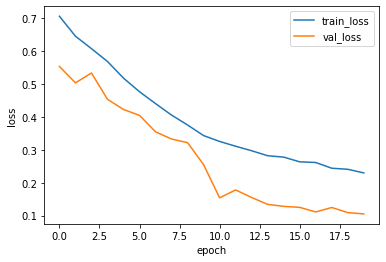

In [34]:
import matplotlib.pyplot as plt
plt.plot(loss[0],label='train_loss')
plt.plot(loss[1],label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc="upper right")
#plt.xticks([i for i in range(1,21)])

In [33]:
test()

env default
model VGG19bn_custom
train_data_root I:/data/dogcat/train/train/
test_data_root I:/data/dogcat/test/test/
load_model_path I:/torch/dogcat_model/VGG13_0609.pth
batch_size 8
use_gpu True
num_workers 0
print_freq 20
debug_file /tmp/debug
result_file I:/data/dogcat/result/submission2.csv
max_epoch 20
lr 0.01
lr_decay 0.95
weight_decay 0.001
parse <bound method DefaultConfig.parse of <__main__.DefaultConfig object at 0x0000024BC77F9978>>
测试集的数目为： 12500


D:\anaconda\envs\forPytorch\lib\site-packages\ipykernel_launcher.py:22: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


[(1, 0.2689414322376251),
 (2, 0.2689414322376251),
 (3, 0.2689414918422699),
 (4, 0.26894238591194153),
 (5, 0.7310585379600525),
 (6, 0.7310585379600525),
 (7, 0.7310585379600525),
 (8, 0.7310582399368286),
 (9, 0.7310585379600525),
 (10, 0.7310585379600525),
 (11, 0.7310582995414734),
 (12, 0.2689414322376251),
 (13, 0.7310582995414734),
 (14, 0.26967957615852356),
 (15, 0.7310585379600525),
 (16, 0.730887234210968),
 (17, 0.2740548253059387),
 (18, 0.2689414322376251),
 (19, 0.7310585379600525),
 (20, 0.7310585379600525),
 (21, 0.2689414322376251),
 (22, 0.7310585379600525),
 (23, 0.2689414322376251),
 (24, 0.26894378662109375),
 (25, 0.7310585379600525),
 (26, 0.2689414322376251),
 (27, 0.2689414322376251),
 (28, 0.7310585379600525),
 (29, 0.6479806900024414),
 (30, 0.2689414322376251),
 (31, 0.2689414322376251),
 (32, 0.7310261130332947),
 (33, 0.2689414322376251),
 (34, 0.7310585379600525),
 (35, 0.7310585379600525),
 (36, 0.7310452461242676),
 (37, 0.7308787703514099),
 (38, 0.